### Preparation steps

Install iotfunctions with

`pip install git+https://github.com/ibm-watson-iot/functions@development`

This projects contains the code for the Analytics Service pipeline as well as the anomaly functions and should pull in most of this notebook's dependencies.

The plotting library matplotlib is the exception, so you need to run
`pip install matplotlib`


#### Install py4j
In addition install py4j v0.10.9.1-mm from my github clone
`git clone https://github.com/sedgewickmm18/py4j`

Install with
```
cd py4j-java
./gradlew clean assemble # build java jars
cd ..
pip install .  # install python and jars
```

#### Install timeseries-insights
Checkout WatFore forecasting library first

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/WatFore`

then timeseries-insights

`git clone https://github.ibm.com/Common-TimeSeries-Analytics-Library/timeseries-insights`

Finally apply a patch for allow for a callback server IP other than 127.0.0.1

`curl https://raw.githubusercontent.com/sedgewickmm18/tsi/master/context.py.patch | patch -p1`


Build WatFore
```
cd WatFore
mvn clean install -DskipTests
```

Build timeseries-insights
```
cd ../timeseries-insights
mvn clean install -DskipTests
```

Build the python distribution of tspy
```
cd python
python setup.py sdist
```

Install it

`pip install dist/tspy-2.0.5.0.tar.gz`


#### Run timeseries-insights as docker container

`docker run -p 25332:25332 -p 25333:25333 sedgewickmm18/tsi`

* port 25333 exposes the default port for the java server
* port 25332 allows for optional ssh based port forwarding (should not be necessary)

The patch above allows for callback server IP addresses other than 127.0.0.1, i.e. the python client that also acts as callback server for python lambda processing can listen to a docker bridge IP address. In my case I'm running it from my laptop on `172.17.0.1` while the container with the java process has IP address `172.17.0.2`.

##### Caveat:

The java process attempts to listen to IPv4 **and** IPv6 addresses so have to enable IPv6 for your docker bridge with

`sudo vi /etc/docker/daemon.json`

so that it looks similar to

```
{
    "insecure-registries" : ["localhost:32000"],
    "ipv6": true,
    "fixed-cidr-v6": "2001:db8:1::/64"
}
```

Then restart the docker daemon with

`systemctl restart docker`

and check with

`docker network inspect bridge`

In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore,
                 SaliencybasedGeneralizedAnomalyScorev2, FFTbasedGeneralizedAnomalyScorev2, 
                 KMeansAnomalyScorev2)                 
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Vx'
kmeans0='TemperatureKmeansScore0'
kmeans='TemperatureKmeansScore'
fft0='FFTAnomalyScore0'
fft='FFTAnomalyScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansA0='kmeansAnomaly0'
spectralA='spectralAnomaly'
fftA0='fftAnomaly0'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
# set up a db object with a FileModelStore to support scaling
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-09-21T16:24:13.598 INFO iotfunctions.dbtables.__init__ Init FileModelStore


In [4]:
# Run on the good pump first 
# Get stuff in
df_i = pd.read_csv('AllOfArmstark.csv', index_col=False, parse_dates=['timestamp'])

#df_i['entity']='MyRoom'
#df_i[Temperature]=df_i['value'] + 20
#df_i = df_i.drop(columns=['value'])

# and sort it by timestamp
df_i = df_i.sort_values(by='timestamp')
df_i = df_i.set_index(['entity','timestamp']).dropna()

df_i.head(2)

,,Vx,Vy,Vz,Ap,As,speed
entity,timestamp,,,,,,
04714B604101,2020-01-01 00:02:12.713,-0.0625,-0.0908,-1.0332,2.3650,1.036,1.042
04714B6046D5,2020-01-01 00:02:25.928,-0.0439,-0.0137,-1.0029,2.2904,1.036,1.036


In [5]:
# Now run the anomaly functions as if they were executed in a pipeline

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}


spsi = SpectralAnomalyScore(Temperature, 12, spectral)
et = spsi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
spsi._entity_type = et
df_i = spsi.execute(df=df_i)

sali = SaliencybasedGeneralizedAnomalyScorev2(Temperature, 12, True, sal)
et = sali._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
sali._entity_type = et
df_i = sali.execute(df=df_i)


ffti0 = FFTbasedGeneralizedAnomalyScorev2(Temperature, 12, True, fft0)
et = ffti0._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
ffti0._entity_type = et
df_i = ffti0.execute(df=df_i)

#EngineLogging.configure_console_logging(logging.DEBUG)
ffti = FFTbasedGeneralizedAnomalyScorev2(Temperature, 12, True, fft)
et = ffti._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
ffti._entity_type = et
df_i = ffti.execute(df=df_i)
#EngineLogging.configure_console_logging(logging.INFO)

kmi0 = KMeansAnomalyScore(Temperature, 12, kmeans0)
et = kmi0._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kmi0._entity_type = et
df_i = kmi0.execute(df=df_i)

kmi = KMeansAnomalyScorev2(Temperature, 12, True, kmeans)
et = kmi._build_entity_type(columns = [Column(Temperature,Float())], **jobsettings)
kmi._entity_type = et
df_i = kmi.execute(df=df_i)

df_i.describe()

2020-09-21T15:37:55.515 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2020-09-21T15:38:03.016 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-09-21T15:38:03.049 INFO iotfunctions.base.get_models_for_training predicting target SaliencyAnomalyScore
2020-09-21T15:38:03.050 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SALIENCYBASEDGENERALIZEDANOMALYSCOREV2.SaliencybasedGeneralizedAnomalyScorev2.SaliencyAnomalyScore.04714B604101 of size 1111 bytes has been retrieved from filesystem
2020-09-21T15:38:03.051 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SALIENCYBASEDGENERALIZEDANOMALYSCOREV2.SaliencybasedGeneralizedAnomalyScorev2.SaliencyAnomalyScore.04714B604101",
 "target": "SaliencyAnomalyScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:1

/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Saliencyv2   Entity: 04714B604101, result shape: (21531,) score shape: (21531,) input shape: (129195,)
2020-09-21T15:38:09.457 INFO iotfunctions.base.get_models_for_training predicting target SaliencyAnomalyScore
2020-09-21T15:38:09.458 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SALIENCYBASEDGENERALIZEDANOMALYSCOREV2.SaliencybasedGeneralizedAnomalyScorev2.SaliencyAnomalyScore.04714B6046D5 of size 1111 bytes has been retrieved from filesystem
2020-09-21T15:38:09.459 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SALIENCYBASEDGENERALIZEDANOMALYSCOREV2.SaliencybasedGeneralizedAnomalyScorev2.SaliencyAnomalyScore.04714B6046D5",
 "target": "SaliencyAnomalyScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:12:04.638612",
 "expiry_date": null
}
2020-09-21T15:38:09.459 INFO iotfunctions.base

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


Saliencyv2   Entity: 04714B6046D5, result shape: (21549,) score shape: (21549,) input shape: (129300,)
2020-09-21T15:38:16.213 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-09-21T15:38:16.267 INFO iotfunctions.base.get_models_for_training predicting target FFTAnomalyScore0
2020-09-21T15:38:16.268 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore0.04714B604101 of size 1089 bytes has been retrieved from filesystem
2020-09-21T15:38:16.269 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore0.04714B604101",
 "target": "FFTAnomalyScore0",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_t

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


FFTv2   Entity: 04714B604101, result shape: (21531,) score shape: (21531,) input shape: (129195,)
2020-09-21T15:38:23.204 INFO iotfunctions.base.get_models_for_training predicting target FFTAnomalyScore0
2020-09-21T15:38:23.205 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore0.04714B6046D5 of size 1089 bytes has been retrieved from filesystem
2020-09-21T15:38:23.206 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore0.04714B6046D5",
 "target": "FFTAnomalyScore0",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:12:20.183147",
 "expiry_date": null
}
2020-09-21T15:38:23.206 INFO iotfunctions.base.get_models_for_training training require

/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


FFTv2   Entity: 04714B6046D5, result shape: (21549,) score shape: (21549,) input shape: (129300,)
2020-09-21T15:38:31.489 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-09-21T15:38:31.547 INFO iotfunctions.base.get_models_for_training predicting target FFTAnomalyScore
2020-09-21T15:38:31.548 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore.04714B604101 of size 1086 bytes has been retrieved from filesystem
2020-09-21T15:38:31.549 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore.04714B604101",
 "target": "FFTAnomalyScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,

/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


FFTv2   Entity: 04714B604101, result shape: (21531,) score shape: (21531,) input shape: (129195,)
2020-09-21T15:38:38.950 INFO iotfunctions.base.get_models_for_training predicting target FFTAnomalyScore
2020-09-21T15:38:38.950 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore.04714B6046D5 of size 1086 bytes has been retrieved from filesystem
2020-09-21T15:38:38.951 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_FFTBASEDGENERALIZEDANOMALYSCOREV2.FFTbasedGeneralizedAnomalyScorev2.FFTAnomalyScore.04714B6046D5",
 "target": "FFTAnomalyScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:12:40.311095",
 "expiry_date": null
}
2020-09-21T15:38:38.952 INFO iotfunctions.base.get_models_for_training training required: F

/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


FFTv2   Entity: 04714B6046D5, result shape: (21549,) score shape: (21549,) input shape: (129300,)
2020-09-21T15:38:47.538 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2020-09-21T15:39:10.190 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-09-21T15:39:10.257 INFO iotfunctions.base.get_models_for_training predicting target TemperatureKmeansScore
2020-09-21T15:39:10.257 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScorev2.TemperatureKmeansScore.04714B604101 of size 1081 bytes has been retrieved from filesystem
2020-09-21T15:39:10.258 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScorev2.TemperatureKmeansScore.04714B604101",
 "target": "TemperatureKmeansScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:13:14.369996",
 "expiry_date": null
}
2020-09-21T15:39:10.258 INF

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


predicted_TemperatureKmeansScore
2020-09-21T15:39:21.220 INFO iotfunctions.base.get_models_for_training predicting target TemperatureKmeansScore
2020-09-21T15:39:21.221 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScorev2.TemperatureKmeansScore.04714B6046D5 of size 1081 bytes has been retrieved from filesystem
2020-09-21T15:39:21.221 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_KMEANSANOMALYSCOREV2.KMeansAnomalyScorev2.TemperatureKmeansScore.04714B6046D5",
 "target": "TemperatureKmeansScore",
 "features": [
  "Vx"
 ],
 "estimator_name": "standard_scaler",
 "eval_metric_name": "r2_score",
 "eval_metric_train": 1,
 "eval_metric_test": 1,
 "trained_date": "2020-09-21T13:13:22.939450",
 "expiry_date": null
}
2020-09-21T15:39:21.221 INFO iotfunctions.base.get_models_for_training training required: False  results: Existing model has not expired and eval metric is good
2020-09-21T15:39:21

/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


predicted_TemperatureKmeansScore


/usr/lib/python3/dist-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3254: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):


,Vx,Vy,Vz,Ap,As,speed,TemperatureSpectralScore,SaliencyAnomalyScore,FFTAnomalyScore0,FFTAnomalyScore,TemperatureKmeansScore0,TemperatureKmeansScore
count,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000,258495.000000
mean,-0.006552,-0.027379,-0.959099,2.430800,0.971285,0.971500,23.888282,33.969701,19.461067,19.461563,0.144935,2.552600
std,0.061913,0.037608,0.073353,0.903795,0.288768,0.288164,23.329222,44.577354,17.395616,17.394044,0.085529,1.109127
min,-0.481400,-0.359400,-1.415000,0.000000,0.000000,0.000000,0.005022,0.246555,0.018369,0.018386,0.009788,0.112293
25%,-0.034200,-0.044900,-0.999000,2.260200,1.032000,1.031744,12.135650,5.916233,8.411101,8.412345,0.085639,1.897026
50%,-0.003900,-0.027300,-0.960000,2.330400,1.037000,1.037000,19.219404,17.180406,13.800854,13.802829,0.122849,2.382713
75%,0.027300,-0.009800,-0.922900,2.677800,1.057000,1.057954,27.366263,42.201716,25.303662,25.307628,0.182410,3.133516
max,0.575200,0.286100,-0.474600,5.401600,1.201000,1.195605,602.839913,606.266591,237.499285,237.489195,0.699949,9.846163


In [6]:
# Simplify our pandas dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)

df_inputm2 = df_i.loc[['04714B6046D5']]
df_inputm2.reset_index(level=[0], inplace=True)

# predicted just means normalized - need to modify the BaseEstimatorFunction superclass
predKM = 'predicted_TemperatureKmeansScore'
predFFT = 'predicted_FFTAnomalyScore'

<ipython-input-7-39112e40e436>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputm2[kmeansA] = df_inputm2[kmeans]
<ipython-input-7-39112e40e436>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputm2[kmeansA0] = df_inputm2[kmeans0]
<ipython-input-7-39112e40e436>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_

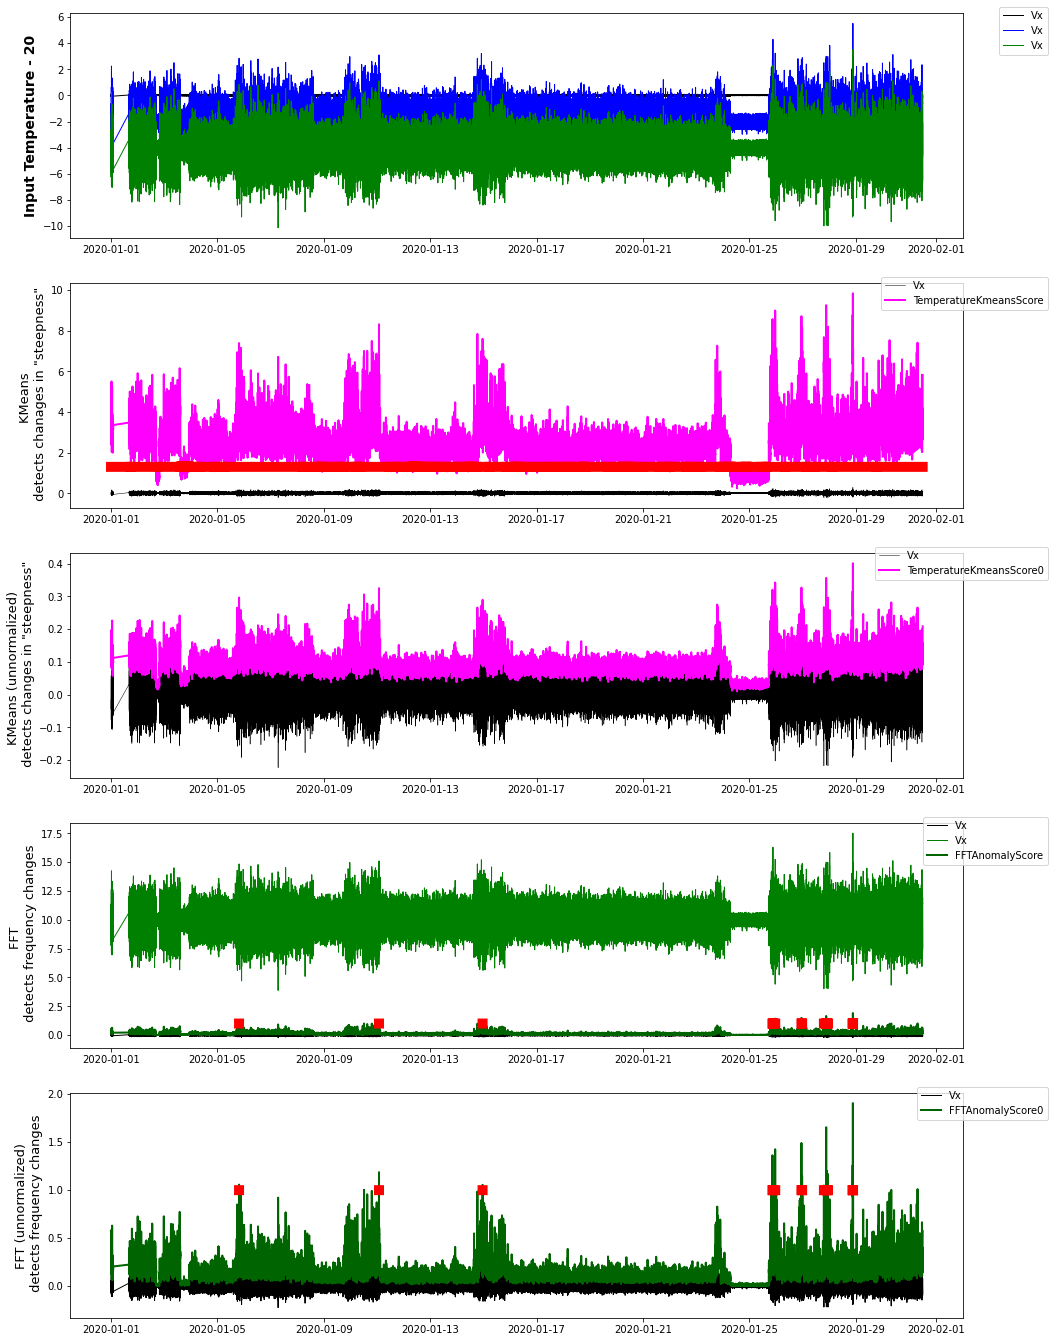

In [7]:
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break

df_inputm2[kmeansA0] = df_inputm2[kmeans0]
df_inputm2[kmeansA0].values[df_inputm2[kmeansA0] < kmeans_break] = np.nan
df_inputm2[kmeansA0].values[df_inputm2[kmeansA0] > kmeans_break] = kmeans_break

df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break

df_inputm2[fftA0] = df_inputm2[fft0]
df_inputm2[fftA0].values[df_inputm2[fftA0] < fft_break] = np.nan
df_inputm2[fftA0].values[df_inputm2[fftA0] > fft_break] = fft_break

plots = 5

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[predKM]-2,linewidth=1,color='blue',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[predFFT]-4,linewidth=1,color='green',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=0.5,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=0.5,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans0], linewidth=2, color='magenta',label=kmeans0)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA0], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans (unnormalized) \n detects changes in "steepness"',fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[predFFT]+10,linewidth=1,color='green',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft0]/fft_break, linewidth=2,color='darkgreen',label=fft0)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA0]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT (unnormalized)\n detects frequency changes', fontsize=13)
cnt = 5

In [5]:
# start the callback server

#from tspy import TSContext
import tspy
from tspy.data_structures.context import TSContext 
from py4j.java_gateway import JavaGateway, GatewayParameters, CallbackServerParameters


gateway = JavaGateway(gateway_parameters=GatewayParameters(address=u'172.17.0.2',
                                  auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA='),
            callback_server_parameters=CallbackServerParameters(daemonize=True,port=25334,address=u'172.17.0.1',
                         auth_token='DZQv45+bq4TTHSF3FH2RoYqLoGjY2zMcojcQQpRFZMA=',daemonize_connections=True))



2020-09-21T16:24:36.573 INFO py4j.java_gateway.run Callback Server Starting
2020-09-21T16:24:36.574 INFO py4j.java_gateway.run Socket listening on ('172.17.0.1', 25334)


In [6]:
df_i

Vx      Vy      Vz      Ap     As  \
entity       timestamp                                                        
04714B604101 2020-01-01 00:02:12.713 -0.0625 -0.0908 -1.0332  2.3650  1.036   
04714B6046D5 2020-01-01 00:02:25.928 -0.0439 -0.0137 -1.0029  2.2904  1.036   
04714B604101 2020-01-01 00:03:12.713  0.0361  0.0078 -0.9141  2.3650  1.036   
04714B6046D5 2020-01-01 00:03:25.928 -0.0430 -0.0205 -0.9023  2.2904  1.036   
04714B604101 2020-01-01 00:04:12.713  0.1172 -0.0332 -0.9756  2.3650  1.036   
...                                      ...     ...     ...     ...    ...   
             2020-01-31 12:10:16.047 -0.0088 -0.0361 -0.9160  2.2800  1.032   
04714B6046D5 2020-01-31 12:10:23.501 -0.0879 -0.0322 -0.8750  2.2760  1.037   
             2020-01-31 12:11:23.501  0.0596 -0.0166 -0.9795  2.2744  1.037   
             2020-01-31 12:12:23.501  0.0801 -0.0215 -1.0166  2.2744  1.037   
             2020-01-31 12:13:23.501 -0.0957  0.0029 -0.9854  2.2744  1.037   

                                      speed  
entity       timestamp                       
04714B604101 2020-01-01 00:02:12.713  1.042  
04714B6046D5 2020-01-01 00:02:25.928  1.036  
04714B604101 2020-01-01 00:03:12.713  1.042  
04714B6046D5 2020-01-01 00:03:25.928  1.036  
04714B604101 2020-01-01 00:04:12.713  1.042  
...                                     ...  
             2020-01-31 12:10:16.047  1.033  
04714B6046D5 2020-01-31 12:10:23.501  1.037  
             2020-01-31 12:11:23.501  1.037  
             2020-01-31 12:12:23.501  1.037  
             2020-01-31 12:13:23.501  1.037  

[258495 rows x 6 columns]

In [76]:
import datetime

df = df_i.reset_index()[['entity','timestamp','Vx']] #['entity'=='04714B6046D5']
df = df[df['entity']=='04714B6046D5']


tsc = TSContext(gateway=gateway, jvm=gateway.jvm, daemonize=True)

model = tspy.forecasters.arima(500)

model_map = {
        '04714B6046D5': model,
}

2020-09-21T16:48:54.296 INFO py4j.java_gateway.run Received command  on object id 
2020-09-21T16:48:54.297 INFO py4j.java_gateway.run Received command  on object id 
2020-09-21T16:48:54.297 INFO py4j.java_gateway.run Received command  on object id 
2020-09-21T16:48:54.298 INFO py4j.java_gateway.close Closing down callback connection
2020-09-21T16:48:54.299 INFO py4j.java_gateway.close Closing down callback connection
2020-09-21T16:48:54.300 INFO py4j.java_gateway.close Closing down callback connection
2020-09-21T16:48:59.396 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-09-21T16:48:59.397 INFO py4j.java_gateway.run Received command g on object id p626
2020-09-21T16:48:59.398 INFO py4j.java_gateway.run Received command g on object id p627
2020-09-21T16:48:59.398 INFO py4j.java_gateway.run Received command g on object id p628
2020-09-21T16:48:59.399 INFO py4j.java_gateway.run Received command g on object id p629
2020-09-21T16:48:59.399 INFO py4j.java_gatew

2020-09-21T16:48:59.467 INFO py4j.java_gateway.run Received command g on object id p373
2020-09-21T16:48:59.467 INFO py4j.java_gateway.run Received command g on object id p332
2020-09-21T16:48:59.468 INFO py4j.java_gateway.run Received command g on object id p331
2020-09-21T16:48:59.468 INFO py4j.java_gateway.run Received command g on object id p750
2020-09-21T16:48:59.469 INFO py4j.java_gateway.run Received command g on object id p687
2020-09-21T16:48:59.469 INFO py4j.java_gateway.run Received command g on object id p686
2020-09-21T16:48:59.470 INFO py4j.java_gateway.run Received command g on object id p685
2020-09-21T16:48:59.470 INFO py4j.java_gateway.run Received command g on object id p684
2020-09-21T16:48:59.471 INFO py4j.java_gateway.run Received command g on object id p683
2020-09-21T16:48:59.471 INFO py4j.java_gateway.run Received command g on object id p682
2020-09-21T16:48:59.472 INFO py4j.java_gateway.run Received command g on object id p681
2020-09-21T16:48:59.472 INFO py4

2020-09-21T16:48:59.579 INFO py4j.java_gateway.run Received command g on object id p204
2020-09-21T16:48:59.579 INFO py4j.java_gateway.run Received command g on object id p205
2020-09-21T16:48:59.580 INFO py4j.java_gateway.run Received command g on object id p394
2020-09-21T16:48:59.580 INFO py4j.java_gateway.run Received command g on object id p395
2020-09-21T16:48:59.581 INFO py4j.java_gateway.run Received command g on object id p396
2020-09-21T16:48:59.581 INFO py4j.java_gateway.run Received command g on object id p397
2020-09-21T16:48:59.582 INFO py4j.java_gateway.run Received command g on object id p605
2020-09-21T16:48:59.582 INFO py4j.java_gateway.run Received command g on object id p606
2020-09-21T16:48:59.583 INFO py4j.java_gateway.run Received command g on object id p607
2020-09-21T16:48:59.583 INFO py4j.java_gateway.run Received command g on object id p608
2020-09-21T16:48:59.584 INFO py4j.java_gateway.run Received command g on object id p609
2020-09-21T16:48:59.584 INFO py4

2020-09-21T16:48:59.660 INFO py4j.java_gateway.run Received command g on object id p347
2020-09-21T16:48:59.661 INFO py4j.java_gateway.run Received command g on object id p348
2020-09-21T16:48:59.661 INFO py4j.java_gateway.run Received command g on object id p349
2020-09-21T16:48:59.662 INFO py4j.java_gateway.run Received command g on object id p351
2020-09-21T16:48:59.663 INFO py4j.java_gateway.run Received command g on object id p352
2020-09-21T16:48:59.664 INFO py4j.java_gateway.run Received command g on object id p398
2020-09-21T16:48:59.665 INFO py4j.java_gateway.run Received command g on object id p641
2020-09-21T16:48:59.665 INFO py4j.java_gateway.run Received command g on object id p642
2020-09-21T16:48:59.666 INFO py4j.java_gateway.run Received command g on object id p643
2020-09-21T16:48:59.667 INFO py4j.java_gateway.run Received command g on object id p644
2020-09-21T16:48:59.668 INFO py4j.java_gateway.run Received command g on object id p645
2020-09-21T16:48:59.668 INFO py4

2020-09-21T16:48:59.751 INFO py4j.java_gateway.run Received command g on object id p432
2020-09-21T16:48:59.752 INFO py4j.java_gateway.run Received command g on object id p461
2020-09-21T16:48:59.752 INFO py4j.java_gateway.run Received command g on object id p462
2020-09-21T16:48:59.753 INFO py4j.java_gateway.run Received command g on object id p463
2020-09-21T16:48:59.753 INFO py4j.java_gateway.run Received command g on object id p464
2020-09-21T16:48:59.754 INFO py4j.java_gateway.run Received command g on object id p465
2020-09-21T16:48:59.756 INFO py4j.java_gateway.run Received command g on object id p466
2020-09-21T16:48:59.757 INFO py4j.java_gateway.run Received command g on object id p487
2020-09-21T16:48:59.759 INFO py4j.java_gateway.run Received command g on object id p488
2020-09-21T16:48:59.760 INFO py4j.java_gateway.run Received command g on object id p489
2020-09-21T16:48:59.761 INFO py4j.java_gateway.run Received command g on object id p490
2020-09-21T16:48:59.762 INFO py4

2020-09-21T16:48:59.852 INFO py4j.java_gateway.run Received command g on object id p517
2020-09-21T16:48:59.855 INFO py4j.java_gateway.run Received command g on object id p518
2020-09-21T16:48:59.857 INFO py4j.java_gateway.run Received command g on object id p519
2020-09-21T16:48:59.858 INFO py4j.java_gateway.run Received command g on object id p520
2020-09-21T16:48:59.859 INFO py4j.java_gateway.run Received command g on object id p521
2020-09-21T16:48:59.860 INFO py4j.java_gateway.run Received command g on object id p578
2020-09-21T16:48:59.861 INFO py4j.java_gateway.run Received command g on object id p579
2020-09-21T16:48:59.862 INFO py4j.java_gateway.run Received command g on object id p580
2020-09-21T16:48:59.863 INFO py4j.java_gateway.run Received command g on object id p581
2020-09-21T16:48:59.864 INFO py4j.java_gateway.run Received command g on object id p582
2020-09-21T16:48:59.865 INFO py4j.java_gateway.run Received command g on object id p583
2020-09-21T16:48:59.865 INFO py4

In [77]:
df

,entity,timestamp,Vx
1,04714B6046D5,2020-01-01 00:02:25.928,-0.0439
3,04714B6046D5,2020-01-01 00:03:25.928,-0.0430
5,04714B6046D5,2020-01-01 00:04:25.928,0.0039
7,04714B6046D5,2020-01-01 00:05:25.928,0.0283
9,04714B6046D5,2020-01-01 00:06:25.928,-0.0771
...,...,...,...
258489,04714B6046D5,2020-01-31 12:09:23.501,0.0293
258491,04714B6046D5,2020-01-31 12:10:23.501,-0.0879
258492,04714B6046D5,2020-01-31 12:11:23.501,0.0596
258493,04714B6046D5,2020-01-31 12:12:23.501,0.0801


In [48]:
dfs = df.tail(20000)
mts_raw = tsc.multi_time_series\
        .df_observations(dfs, dfs.keys()[0], dfs.keys()[1], dfs.keys()[2], granularity=datetime.timedelta(milliseconds=1))\
        .with_trs(granularity=datetime.timedelta(minutes=1)) \
        .transform(tsc.duplicate_transforms.combine_duplicate_time_ticks(lambda x: float(sum(x) / len(x))))

In [67]:
dfss = mts_raw.to_df()

In [68]:
dfss

,timestamp,key,value
0,26334532,04714B6046D5,-0.020500
1,26334533,04714B6046D5,-0.009067
2,26334534,04714B6046D5,0.026700
3,26334535,04714B6046D5,0.069300
4,26334536,04714B6046D5,0.015300
...,...,...,...
6677,26341209,04714B6046D5,0.029300
6678,26341210,04714B6046D5,-0.087900
6679,26341211,04714B6046D5,0.059600
6680,26341212,04714B6046D5,0.080100


In [78]:
model.update_model(dfss['timestamp'].astype(int).tolist(), dfss['value'].tolist())
#model.update_model(mts_raw)

In [79]:
model

Forecasting Model
  Algorithm: RegularARIMAAlgorithm [armaAlgorithm=RegularARMAAlgorithm [dataHistory=WeightedHistory [weights=[-0.20176167052768776, -0.5883934830656194], history=com.ibm.watson.pm.util.CircularBuffer@c2a4c920, historyLength=2, dataCount=6682], errorHistory=WeightedHistory [weights=null, history=null, historyLength=0, dataCount=0], dataMean=0.008636178861788515, minTrainingData=80, pMin=0, pMax=5, qMin=0, qMax=5, forceModel=false], differencer=null, minTrainingData=82, diffOrder=-1]

In [80]:
forecasts = mts_raw.forecast(100, model_map, confidence=0.97)

In [81]:
df2 = mts_raw.to_df()

In [82]:
df2.describe()

,timestamp,value
count,6.682000e+03,6682.000000
mean,2.633787e+07,0.007490
std,1.929072e+03,0.026912
min,2.633453e+07,-0.129233
25%,2.633620e+07,-0.010067
50%,2.633787e+07,0.007800
75%,2.633954e+07,0.024400
max,2.634121e+07,0.151367


In [83]:
for k, series in forecasts.items():
    for k2 in series:
        print(k2)
        print(k2.value)
        ser = pd.Series
        df2 = df2.append({'timestamp': k2.time_tick, 'key': k, 'value': k2.value['value']}, ignore_index=True)

2020-09-21T16:49:49.105 INFO py4j.java_gateway.run Received command c on object id p2022
2020-09-21T16:49:49.107 INFO py4j.java_gateway.run Callback Connection ready to receive messages
2020-09-21T16:49:49.107 INFO py4j.java_gateway.run Received command c on object id p1922
TimeStamp: 26341214     Value: {value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-09-21T16:49:49.109 INFO py4j.java_gateway.run Received command c on object id p1922
{value=-0.012361626027272043, lower_bound=-0.06894428353943802, upper_bound=0.044221031484893925, error=0.02607387143524321}
2020-09-21T16:49:49.110 INFO py4j.java_gateway.run Received command c on object id p1922
2020-09-21T16:49:49.124 INFO py4j.java_gateway.run Received command c on object id p2023
2020-09-21T16:49:49.125 INFO py4j.java_gateway.run Received command c on object id p1923
TimeStamp: 26341215     Value: {value=0.07426345874386522, lower_bound=0.016315441143630

{value=0.012112107001388702, lower_bound=-0.045882411071741916, upper_bound=0.07010662507451931, error=0.026724471325203617}
2020-09-21T16:49:49.281 INFO py4j.java_gateway.run Received command c on object id p1934
2020-09-21T16:49:49.288 INFO py4j.java_gateway.run Received command c on object id p2035
2020-09-21T16:49:49.289 INFO py4j.java_gateway.run Received command c on object id p1935
TimeStamp: 26341227     Value: {value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-09-21T16:49:49.291 INFO py4j.java_gateway.run Received command c on object id p1935
{value=0.008916502081850356, lower_bound=-0.04908985798539367, upper_bound=0.06692286214909438, error=0.026729928238074553}
2020-09-21T16:49:49.292 INFO py4j.java_gateway.run Received command c on object id p1935
2020-09-21T16:49:49.306 INFO py4j.java_gateway.run Received command c on object id p2036
2020-09-21T16:49:49.307 INFO py4j.java_gateway.run Received co

TimeStamp: 26341239     Value: {value=0.008522895205748598, lower_bound=-0.04952437209297163, upper_bound=0.06657016250446882, error=0.026748778711721054}
2020-09-21T16:49:49.446 INFO py4j.java_gateway.run Received command c on object id p1947
{value=0.008522895205748598, lower_bound=-0.04952437209297163, upper_bound=0.06657016250446882, error=0.026748778711721054}
2020-09-21T16:49:49.447 INFO py4j.java_gateway.run Received command c on object id p1947
2020-09-21T16:49:49.453 INFO py4j.java_gateway.run Received command c on object id p2048
2020-09-21T16:49:49.454 INFO py4j.java_gateway.run Received command c on object id p1948
TimeStamp: 26341240     Value: {value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239163}
2020-09-21T16:49:49.463 INFO py4j.java_gateway.run Received command c on object id p1948
{value=0.008639791994079278, lower_bound=-0.049410828273346315, upper_bound=0.06669041226150488, error=0.026750323794239

{value=0.008635808671880163, lower_bound=-0.049354766168494574, upper_bound=0.0666263835122549, error=0.026722654242930768}
2020-09-21T16:49:49.602 INFO py4j.java_gateway.run Received command c on object id p1959
2020-09-21T16:49:49.612 INFO py4j.java_gateway.run Received command c on object id p2060
2020-09-21T16:49:49.613 INFO py4j.java_gateway.run Received command c on object id p1960
TimeStamp: 26341252     Value: {value=0.008639794367258063, lower_bound=-0.04935426558391793, upper_bound=0.06663385431843405, error=0.026724260217887846}
2020-09-21T16:49:49.614 INFO py4j.java_gateway.run Received command c on object id p1960
{value=0.008639794367258063, lower_bound=-0.04935426558391793, upper_bound=0.06663385431843405, error=0.026724260217887846}
2020-09-21T16:49:49.615 INFO py4j.java_gateway.run Received command c on object id p1960
2020-09-21T16:49:49.621 INFO py4j.java_gateway.run Received command c on object id p2061
2020-09-21T16:49:49.623 INFO py4j.java_gateway.run Received com

{value=0.00863616904956994, lower_bound=-0.04933937548088295, upper_bound=0.06661171358002282, error=0.026715728121292703}
2020-09-21T16:49:49.760 INFO py4j.java_gateway.run Received command c on object id p1972
2020-09-21T16:49:49.768 INFO py4j.java_gateway.run Received command c on object id p2073
2020-09-21T16:49:49.769 INFO py4j.java_gateway.run Received command c on object id p1973
TimeStamp: 26341265     Value: {value=0.008636065849653388, lower_bound=-0.04934302715006582, upper_bound=0.0666151588493726, error=0.026717363292483136}
2020-09-21T16:49:49.771 INFO py4j.java_gateway.run Received command c on object id p1973
{value=0.008636065849653388, lower_bound=-0.04934302715006582, upper_bound=0.0666151588493726, error=0.026717363292483136}
2020-09-21T16:49:49.772 INFO py4j.java_gateway.run Received command c on object id p1973
2020-09-21T16:49:49.779 INFO py4j.java_gateway.run Received command c on object id p2074
2020-09-21T16:49:49.780 INFO py4j.java_gateway.run Received comman

{value=0.008636179855052916, lower_bound=-0.049358443585594255, upper_bound=0.06663080329570009, error=0.02672451987964063}
2020-09-21T16:49:49.932 INFO py4j.java_gateway.run Received command c on object id p1985
2020-09-21T16:49:49.939 INFO py4j.java_gateway.run Received command c on object id p2086
2020-09-21T16:49:49.941 INFO py4j.java_gateway.run Received command c on object id p1986
TimeStamp: 26341278     Value: {value=0.00863618231877197, lower_bound=-0.04936106883736113, upper_bound=0.06663343347490507, error=0.02672573075800444}
2020-09-21T16:49:49.943 INFO py4j.java_gateway.run Received command c on object id p1986
{value=0.00863618231877197, lower_bound=-0.04936106883736113, upper_bound=0.06663343347490507, error=0.02672573075800444}
2020-09-21T16:49:49.944 INFO py4j.java_gateway.run Received command c on object id p1986
2020-09-21T16:49:49.951 INFO py4j.java_gateway.run Received command c on object id p2087
2020-09-21T16:49:49.952 INFO py4j.java_gateway.run Received command

{value=0.008636178809151431, lower_bound=-0.04931799814441591, upper_bound=0.06659035576271877, error=0.026705881721758064}
2020-09-21T16:49:50.100 INFO py4j.java_gateway.run Received command c on object id p1998
2020-09-21T16:49:50.108 INFO py4j.java_gateway.run Received command c on object id p2099
2020-09-21T16:49:50.116 INFO py4j.java_gateway.run Received command g on object id p2097
2020-09-21T16:49:50.116 INFO py4j.java_gateway.run Received command c on object id p1999
2020-09-21T16:49:50.117 INFO py4j.java_gateway.run Received command g on object id p2096
2020-09-21T16:49:50.118 INFO py4j.java_gateway.run Received command g on object id p2095
TimeStamp: 26341291     Value: {value=0.008636178758488754, lower_bound=-0.04931877175592814, upper_bound=0.06659112927290564, error=0.02670623818656593}
2020-09-21T16:49:50.119 INFO py4j.java_gateway.run Received command c on object id p1999
{value=0.008636178758488754, lower_bound=-0.04931877175592814, upper_bound=0.06659112927290564, err

TimeStamp: 26341303     Value: {value=0.008636178864098574, lower_bound=-0.049280043831940706, upper_bound=0.06655240156013785, error=0.026688392008925223}
2020-09-21T16:49:50.291 INFO py4j.java_gateway.run Received command c on object id p2011
{value=0.008636178864098574, lower_bound=-0.049280043831940706, upper_bound=0.06655240156013785, error=0.026688392008925223}
2020-09-21T16:49:50.292 INFO py4j.java_gateway.run Received command c on object id p2011
2020-09-21T16:49:50.299 INFO py4j.java_gateway.run Received command c on object id p2112
2020-09-21T16:49:50.300 INFO py4j.java_gateway.run Received command c on object id p2012
TimeStamp: 26341304     Value: {value=0.008636178864794307, lower_bound=-0.04927520425724051, upper_bound=0.06654756198682912, error=0.026686161883371886}
2020-09-21T16:49:50.302 INFO py4j.java_gateway.run Received command c on object id p2012
{value=0.008636178864794307, lower_bound=-0.04927520425724051, upper_bound=0.06654756198682912, error=0.026686161883371

Text(0, 0.5, 'Pump Vibration')

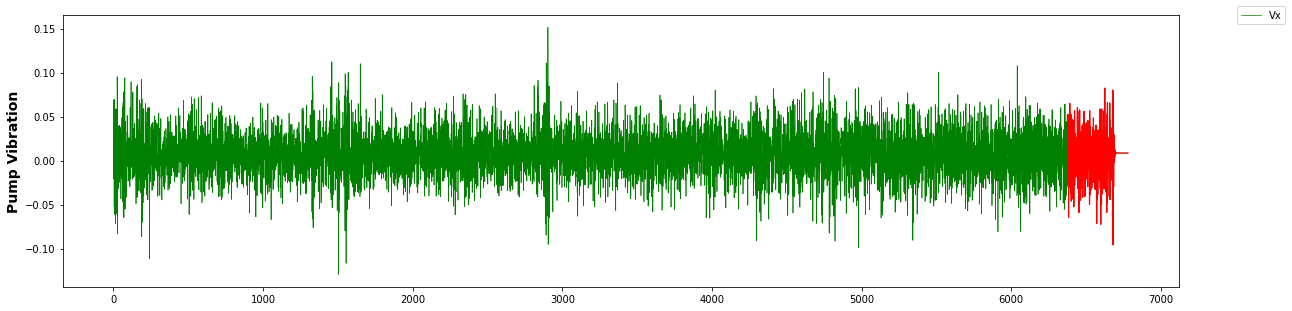

In [88]:
dftail = df2.tail(400)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot(df2.index, df2['value'],linewidth=0.7,color='green',label=Temperature)
ax.plot(dftail.index, dftail['value'],linewidth=1.2,color='red')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Pump Vibration',fontsize=14,weight="bold")

#### nothing of interest below ... ;-)

just a lot of really old stuff 

In [146]:
# df_inputm2[spectral].values[df_inputm2[spectral] > 0.001] = 0.001
# df_inputm2[fft].values[df_inputm2[fft] < -1] = -1
df_inputm2[kmeansA] = df_inputm2[kmeans]
df_inputm2[kmeansA].values[df_inputm2[kmeansA] < kmeans_break] = np.nan
df_inputm2[kmeansA].values[df_inputm2[kmeansA] > kmeans_break] = kmeans_break
df_inputm2[kmeansB] = df_inputm2[kmeans]
df_inputm2[kmeansB].values[df_inputm2[kmeansB] >= kmeans_break] = 4
df_inputm2[kmeansB].values[df_inputm2[kmeansB] < kmeans_break] = 3

# Scale spectral and saliency 
# df_inputm2[spectral].values[df_inputm2[spectral] >= spectral_break] = -spectral_break
# df_inputm2[sal].values[df_inputm2[sal] > sal_break] = sal_break



df_inputm2[fftA] = df_inputm2[fft]
df_inputm2[fftA].values[df_inputm2[fftA] < fft_break] = np.nan
df_inputm2[fftA].values[df_inputm2[fftA] > fft_break] = fft_break
df_inputm2[spectralA] = df_inputm2[spectral]
df_inputm2[spectralA].values[df_inputm2[spectralA] < spectral_break] = np.nan
df_inputm2[spectralA].values[df_inputm2[spectralA] > spectral_break] = spectral_break
df_inputm2[salA] = df_inputm2[sal]
df_inputm2[salA].values[df_inputm2[salA] < sal_break] = np.nan
df_inputm2[salA].values[df_inputm2[salA] > sal_break] = sal_break
#df_inputm2[genA] = df_inputm2[gen]
#df_inputm2[genA].values[df_inputm2[genA] < gen_break] = np.nan
#df_inputm2[genA].values[df_inputm2[genA] > gen_break] = gen_break

plots = 5

fig, ax = plt.subplots(plots, 1, figsize=(16,24))
cnt = 0
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input Temperature - 20',fontsize=14,weight="bold")
cnt = 1
#ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Input)
#ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
#ax[cnt].plot(df_inputm2.index, -df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
#ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
#ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt = 1
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputm2.index, df_inputm2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt = 2
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputm2.index, df_inputm2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects frequency changes', fontsize=13)
cnt = 3
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputm2.index, df_inputm2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n like FFT for less "CPU"\n less sensitive', fontsize=13)
cnt = 4
ax[cnt].plot(df_inputm2.index, df_inputm2[Temperature]-20,linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputm2.index, df_inputm2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputm2.index, df_inputm2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n like FFT, part of Azure\'s approach', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

<ipython-input-146-9a44dc620b2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputm2[kmeansA] = df_inputm2[kmeans]


NameError: name 'kmeansB' is not defined

In [62]:
# any detected anomaly segment should overlap with a real anomaly segment (true positive)
# any detected anomaly segment should overlap with only one 'real' anomaly segment 
#   (otherwise it's a hidden false positive)
# any real anomaly must overlap with a detected anomaly (false negative)

anomalyList_ = [('2017-10-09 23:07:00','2017-10-09 23:23:00'),
                ('2017-10-10 13:35:00','2017-10-10 13:36:00'),
                ('2017-10-10 13:38:00','2017-10-10 13:40:00'),
                ('2017-10-10 16:19:00','2017-10-10 16:27:00'),
                ('2017-10-11 00:10:00','2017-10-11 00:17:00'),
                ('2017-10-11 18:11:00','2017-10-11 18:17:00'),
                ('2017-10-12 00:05:00','2017-10-12 00:23:00'),
                ('2017-10-12 08:09:00','2017-10-12 08:12:00'),
                ('2017-10-12 10:34:00','2017-10-12 10:41:00'),
                ('2017-10-12 14:04:00','2017-10-12 14:11:00'),
                ('2017-10-12 16:22:00','2017-10-12 16:28:00'),
                ('2017-10-12 18:52:00','2017-10-12 18:58:00'),
                ('2017-10-12 19:51:00','2017-10-12 19:58:00')]
anomalyList = []

for a in anomalyList_:
    anomalyList.append((pd.Timestamp(a[0]),pd.Timestamp(a[1])))


def get_anom_list(df, label):
    anomList = np.split(df[label], np.where(np.isnan(df[label].values))[0])
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a[~np.isnan(a)] for a in anomList] 
    anomList = [a for a in anomList if not a.empty]
    anomList2 = []
    for a in anomList:
        anomList2.append((a.first('1T').index[0], a.last('1T').index[0]))
    return anomList2

def overlapping_segment(a, b):
    x = max(a[0], b[0])
    y = min(a[1], b[1])
    return x<y

def charact(anomList):
    TP = 0
    FP = 0
    FN = 0

    for i in anomalyList:
        found = False
        for j in anomFFT:
            if overlapping_segment(i,j):
                TP += 1
                found = True
                break
        if not found:
            FN += 1

    for j in anomFFT:
        found = False
        for i in anomalyList:
            if overlapping_segment(i,j):
                found = True
                break
        if not found:
            print(j)
            FP += 1
            
    return TP, FP, FN

    
# split along NaN
anomFFT = get_anom_list(df_inputm2, fftA)

TP, FP, FN = charact(anomFFT)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)

anomKM = get_anom_list(df_inputm2, kmeansA)

TP, FP, FN = charact(anomKM)

print ('TP ', TP, ' FP ', FP, ' FN ', FN)





(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0
(Timestamp('2017-10-12 18:16:00'), Timestamp('2017-10-12 18:37:00'))
TP  13  FP  1  FN  0


#### Results

Clear **winners** are 
* **KMeans** and 
* **FFT**.

Spectral is way too sensitive while Saliency 
doesn't detect the negative peak at 10/10 midnight


In [64]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    l2vib = []
    for index, row in df.iterrows():
        l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
        if col2 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
        if col3 is not None:
            l2vib_element = l2vib_element + \
                            linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2
        l2vib.append(l2vib_element**(1/2))
    df[tcol] = np.asarray(l2vib)
    

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [65]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000


In [66]:
# Run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_input = salii.execute(df=df_input)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_input = spsii.execute(df=df_input)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_input = kmii.execute(df=df_input)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_input = fftii.execute(df=df_input)

df_input.describe()

2020-06-02T14:07:50.781 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:50.782 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.442 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.443 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:07:52.760 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:52.761 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:07:57.854 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8620.000000,8.620000e+03,8620.0,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,1.732051e+00,1.0,2.453523,2.453312,2.452808,2.452053,2.452439,17.785380,25.259561,0.087914,13.626316
std,0.033272,4.441150e-16,0.0,0.856247,0.857594,0.857678,0.857200,0.856340,14.486994,25.227880,0.025500,7.899369
min,3.616515,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.356699,0.005063,0.022573,0.771379
25%,3.737696,1.732051e+00,1.0,2.251800,2.251800,2.252000,2.252000,2.251800,5.833554,10.339797,0.071338,8.418707
50%,3.757949,1.732051e+00,1.0,2.313800,2.313400,2.311800,2.312200,2.312600,14.630254,20.552395,0.085002,12.017826
75%,3.780154,1.732051e+00,1.0,2.691450,2.692100,2.685100,2.681850,2.682300,26.112277,32.141765,0.101584,17.253135
max,3.898555,1.732051e+00,1.0,5.325799,5.293200,5.334001,5.278600,5.282000,98.672447,302.745841,0.217574,63.261967


In [67]:
EngineLogging.configure_console_logging(logging.INFO)

df_input2 = df_input.loc[['04714B6046D5']]
df_input2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_input2

,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:25.928,04714B6046D5,3.787826,1.732051,1.0,2.2904,2.2824,2.2858,2.2956,2.3278,9.955894,34.626486,0.107194,6.657871
2020-01-01 00:07:26.074,04714B6046D5,3.776503,1.732051,1.0,2.2822,2.2978,2.2966,2.3504,2.3190,9.036381,32.208784,0.100376,6.755634
2020-01-01 00:12:25.663,04714B6046D5,3.715573,1.732051,1.0,2.2718,2.2908,2.2912,2.3044,2.3232,8.116868,29.791082,0.093557,6.853397
2020-01-01 00:17:26.020,04714B6046D5,3.765538,1.732051,1.0,2.2748,2.2932,2.2926,2.3146,2.3606,7.197354,27.373380,0.086738,6.951160
2020-01-01 00:22:25.727,04714B6046D5,3.725934,1.732051,1.0,2.3320,2.2980,2.2998,2.3212,2.2860,6.277841,24.955677,0.079920,7.048923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:39:23.476,04714B6046D5,3.725156,1.732051,1.0,2.2778,2.2798,2.2676,2.2718,2.2668,7.662554,8.877056,0.100228,16.899648
2020-01-31 11:44:23.497,04714B6046D5,3.766786,1.732051,1.0,2.2734,2.2704,2.2694,2.2728,2.2670,7.307044,7.748011,0.087977,15.013700
2020-01-31 11:49:23.443,04714B6046D5,3.737750,1.732051,1.0,2.2666,2.2714,2.2712,2.2690,2.2646,6.951534,6.618966,0.075727,13.127752


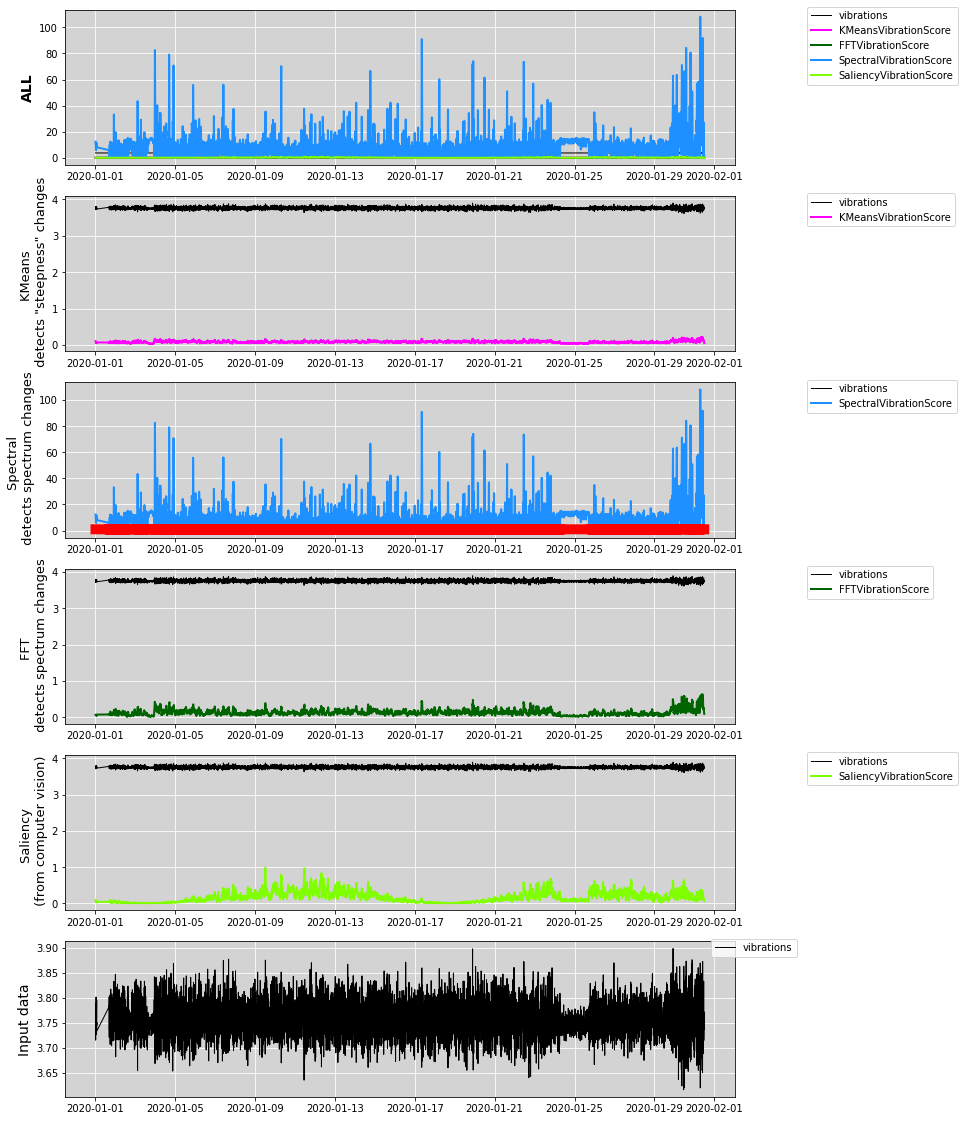

In [68]:
# df_input2[spectral].values[df_input2[spectral] > 0.001] = 0.001
df_input2[fft].values[df_input2[fft] < -1] = -1
df_input2[kmeansA] = df_input2[kmeans]
df_input2[kmeansA].values[df_input2[kmeansA] < kmeans_break] = np.nan
df_input2[kmeansA].values[df_input2[kmeansA] > kmeans_break] = kmeans_break
df_input2[kmeansB] = df_input2[kmeans]
df_input2[kmeansB].values[df_input2[kmeansB] >= kmeans_break] = 4
df_input2[kmeansB].values[df_input2[kmeansB] < kmeans_break] = 3



df_input2[fftA] = df_input2[fft]
df_input2[fftA].values[df_input2[fftA] < fft_break] = np.nan
df_input2[fftA].values[df_input2[fftA] > fft_break] = fft_break
df_input2[spectralA] = df_input2[spectral]
df_input2[spectralA].values[df_input2[spectralA] < spectral_break] = np.nan
df_input2[spectralA].values[df_input2[spectralA] > spectral_break] = spectral_break
df_input2[salA] = df_input2[sal]
df_input2[salA].values[df_input2[salA] < sal_break] = np.nan
df_input2[salA].values[df_input2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt = 0
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[0].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[kmeans], linewidth=2, color='magenta',label=kmeans)
#ax[cnt].plot(df_input2.index, df_input2[kmeansB], linewidth=2, color='yellow') #label=kmeans)
ax[cnt].plot(df_input2.index, df_input2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects "steepness" changes',fontsize=13)
cnt=2
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_input2.index, df_input2[spectralA]/spectral_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_input2.index, df_input2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_input2.index, df_input2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_input2.index, df_input2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (from computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_input2.index, df_input2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_input2.index, df_input2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=14)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')

#ax.set_ylabel('Temperature-50')

In [69]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_inputb_raw['entity']=df_inputb_raw['DEVICE_ID']
df_inputb_raw['timestamp']=df_inputb_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_inputb_raw = df_inputb_raw.sort_values(by='timestamp')
df_inputb_raw = df_inputb_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_inputb_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_inputb_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_inputb_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_inputb_raw)
#l2norm(df_inputb, 'accel_power', 'ACCEL_POWER')

df_inputb = df_inputb_raw.filter(listAttr, axis=1)
df_inputb.head(5)

<ipython-input-64-80608205ccaa>:6: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  l2vib_element = linalg.norm(np.fromstring(row[col1].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:9: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col2].replace('[',' ').replace(']',''), sep = ','))**2
<ipython-input-64-80608205ccaa>:12: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  linalg.norm(np.fromstring(row[col3].replace('[',' ').replace(']',''), sep = ','))**2


vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B604101 2020-01-01 00:02:12.713    3.718562  1.732051          1.0   
             2020-01-01 00:07:12.739    3.786815  1.732051          1.0   
             2020-01-01 00:12:12.769    3.653347  1.732051          1.0   
             2020-01-01 00:17:12.806    3.673086  1.732051          1.0   
             2020-01-01 00:22:13.071    3.754269  1.732051          1.0   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3650         2.3388   
             2020-01-01 00:07:12.739         2.5250         2.3846   
             2020-01-01 00:12:12.769         2.5186         2.3766   
             2020-01-01 00:17:12.806         2.4960         2.3822   
             2020-01-01 00:22:13.071         2.5404         2.3874   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B604101 2020-01-01 00:02:12.713         2.3410         2.3578   
             2020-01-01 00:07:12.739         2.3978         2.3980   
             2020-01-01 00:12:12.769         2.3606         2.4578   
             2020-01-01 00:17:12.806         2.3832         2.4854   
             2020-01-01 00:22:13.071         2.3896         2.4240   

                                      accel_power_4  
entity       timestamp                               
04714B604101 2020-01-01 00:02:12.713         2.5272  
             2020-01-01 00:07:12.739         2.5762  
             2020-01-01 00:12:12.769         2.5150  
             2020-01-01 00:17:12.806         2.3844  
             2020-01-01 00:22:13.071         2.4112

In [70]:
# Again run Monitoring's anomaly detector functions

salii = SaliencybasedGeneralizedAnomalyScore('vibrations', 12, 'SaliencyVibrationScore')
et = salii._build_entity_type(columns = [Column('vibrations',Float())])
salii._entity_type = et
df_inputb = salii.execute(df=df_inputb)


spsii = SpectralAnomalyScore('vibrations', 12, 'SpectralVibrationScore')
et = spsii._build_entity_type(columns = [Column('vibrations',Float())])
spsii._entity_type = et
df_inputb = spsii.execute(df=df_inputb)

kmii = KMeansAnomalyScore('vibrations', 12, 'KMeansVibrationScore')
et = kmii._build_entity_type(columns = [Column('vibrations',Float())])
kmii._entity_type = et
df_inputb = kmii.execute(df=df_inputb)

fftii = FFTbasedGeneralizedAnomalyScore('vibrations', 12, 'FFTVibrationScore')
et = fftii._build_entity_type(columns = [Column('vibrations',Float())])
fftii._entity_type = et
df_inputb = fftii.execute(df=df_inputb)

df_inputb.describe()

2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:05.892 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:07.680 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:07.681 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-06-02T14:08:08.010 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:08.011 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


/home/markus/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


2020-06-02T14:08:13.438 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-06-02T14:08:13.439 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.


,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
count,8613.000000,8.613000e+03,8613.0,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000,8613.000000
mean,3.714736,1.732051e+00,1.0,2.408757,2.409634,2.407835,2.408529,2.409018,26.090731,24.513694,0.219358,25.391862
std,0.088517,4.441150e-16,0.0,0.947978,0.948468,0.947572,0.947615,0.947830,29.013612,26.481873,0.108551,24.427227
min,3.299344,1.732051e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.681661,0.000871,0.000000,0.628891
25%,3.664859,1.732051e+00,1.0,2.268600,2.268400,2.268400,2.268000,2.268600,5.917995,11.303480,0.152590,8.708731
50%,3.701923,1.732051e+00,1.0,2.352200,2.351000,2.349600,2.351600,2.352400,15.897024,19.858287,0.195482,15.403029
75%,3.758416,1.732051e+00,1.0,2.666400,2.685000,2.670600,2.671000,2.675600,33.643744,27.489775,0.285913,37.312574
max,4.221860,1.732051e+00,1.0,5.060000,4.975000,4.883400,5.401600,5.238200,225.329508,324.204142,0.645313,155.118957


In [71]:
EngineLogging.configure_console_logging(logging.INFO)

df_inputb2 = df_inputb.loc[['04714B604101']]
df_inputb2.reset_index(level=[0], inplace=True)

# redefine
# setting to make life easier
Temperature='vibrations'
kmeans='KMeansVibrationScore'
fft='FFTVibrationScore'
spectral='SpectralVibrationScore'
sal='SaliencyVibrationScore'
#gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

kmeans_break=1.3
spectral_break = 2.8
fft_break = 100
sal_break = 100
gen_break = 30000

df_inputb2


,entity,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,SaliencyVibrationScore,SpectralVibrationScore,KMeansVibrationScore,FFTVibrationScore
timestamp,,,,,,,,,,,,,
2020-01-01 00:02:12.713,04714B604101,3.718562,1.732051,1.0,2.3650,2.3388,2.3410,2.3578,2.5272,2.799900,16.799369,0.000000,4.585095
2020-01-01 00:07:12.739,04714B604101,3.786815,1.732051,1.0,2.5250,2.3846,2.3978,2.3980,2.5762,3.258814,15.137877,0.000000,5.662873
2020-01-01 00:12:12.769,04714B604101,3.653347,1.732051,1.0,2.5186,2.3766,2.3606,2.4578,2.5150,3.717728,13.476384,0.000000,6.740650
2020-01-01 00:17:12.806,04714B604101,3.673086,1.732051,1.0,2.4960,2.3822,2.3832,2.4854,2.3844,4.176642,11.814892,0.007647,7.818428
2020-01-01 00:22:13.071,04714B604101,3.754269,1.732051,1.0,2.5404,2.3874,2.3896,2.4240,2.4112,4.635557,10.153400,0.050038,8.896205
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 11:36:16.066,04714B604101,3.670139,1.732051,1.0,2.2880,2.2846,2.2898,2.2878,2.2852,16.980818,152.683720,0.351833,58.467311
2020-01-31 11:41:15.841,04714B604101,3.893611,1.732051,1.0,2.2808,2.2876,2.2852,2.2712,2.2704,16.694134,184.303852,0.372674,59.187724
2020-01-31 11:46:16.049,04714B604101,3.660626,1.732051,1.0,2.2820,2.2724,2.2700,2.2682,2.2706,16.407449,215.923985,0.393515,59.908137


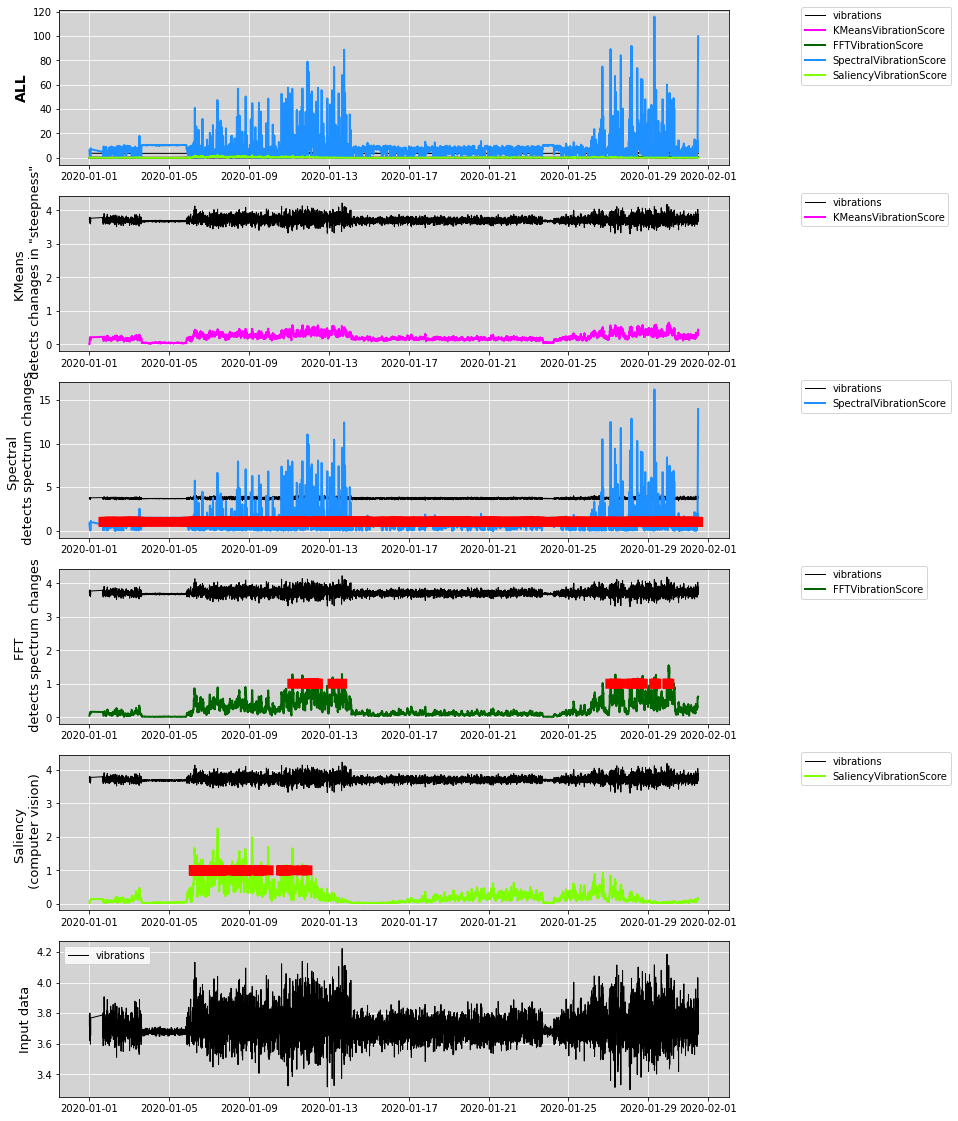

In [72]:
#df_inputb2[spectral].values[df_inputb2[spectral] > 0.001] = 0.001
df_inputb2[fft].values[df_inputb2[fft] < -1] = -1
df_inputb2[kmeansA] = df_inputb2[kmeans]
df_inputb2[kmeansA].values[df_inputb2[kmeansA] < kmeans_break] = np.nan
df_inputb2[kmeansA].values[df_inputb2[kmeansA] > kmeans_break] = kmeans_break
df_inputb2[kmeansB] = df_inputb2[kmeans]
df_inputb2[kmeansB].values[df_inputb2[kmeansB] >= kmeans_break] = 4
df_inputb2[kmeansB].values[df_inputb2[kmeansB] < kmeans_break] = 3



df_inputb2[fftA] = df_inputb2[fft]
df_inputb2[fftA].values[df_inputb2[fftA] < fft_break] = np.nan
df_inputb2[fftA].values[df_inputb2[fftA] > fft_break] = fft_break
df_inputb2[spectralA] = df_inputb2[spectral]
df_inputb2[spectralA].values[df_inputb2[spectralA] < 20] = np.nan
df_inputb2[spectralA].values[df_inputb2[spectralA] > 20] = 20
df_inputb2[salA] = df_inputb2[sal]
df_inputb2[salA].values[df_inputb2[salA] < sal_break] = np.nan
df_inputb2[salA].values[df_inputb2[salA] > sal_break] = sal_break
#df_input2[genA] = df_input2[gen]
#df_input2[genA].values[df_input2[genA] < gen_break] = np.nan
#df_input2[genA].values[df_input2[genA] > gen_break] = gen_break

plots = 6

fig, ax = plt.subplots(plots, 1, figsize=(12,20))
cnt=0
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/spectral_break, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse',label=sal)
#ax[cnt].plot(df_input2.index, df_input2[gen]/gen_break, linewidth=2,color='darkviolet',label=gen)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('ALL',fontsize=14,weight="bold")
cnt=1
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeans], linewidth=2, color='magenta',label=kmeans)
ax[cnt].plot(df_inputb2.index, df_inputb2[kmeansA], linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('KMeans \n detects chanages in "steepness"',fontsize=13)
cnt=2
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectral]/20, linewidth=2,color='dodgerblue', label=spectral)
ax[cnt].plot(df_inputb2.index, df_inputb2[spectralA]/20, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Spectral \n detects spectrum changes', fontsize=13)
cnt=3
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[fft]/fft_break, linewidth=2,color='darkgreen',label=fft)
ax[cnt].plot(df_inputb2.index, df_inputb2[fftA]/fft_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('FFT \n detects spectrum changes', fontsize=13)
cnt=4
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
ax[cnt].plot(df_inputb2.index, df_inputb2[sal]/sal_break, linewidth=2,color='chartreuse', label=sal)
ax[cnt].plot(df_inputb2.index, df_inputb2[salA]/sal_break, linewidth=10, color='red') #,label=kmeansA)
ax[cnt].legend(bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Saliency \n (computer vision)', fontsize=13)
cnt=5
ax[cnt].plot(df_inputb2.index, df_inputb2[Temperature],linewidth=1,color='black',label=Temperature)
#ax[cnt].plot(df_inputb2.index, df_inputb2[gen]/gen_break, linewidth=2,color='darkviolet', label=gen)
#ax[cnt].plot(df_inputb2.index, df_inputb2[genA]/gen_break, linewidth=10, color='red')
ax[cnt].legend()#bbox_to_anchor=(1.1, 1.05))
ax[cnt].set_ylabel('Input data', fontsize=13)

for i in range(plots):
    ax[i].grid(True, color='white')
    ax[i].set_facecolor('lightgrey')


#ax.set_ylabel('Temperature-50')

2020-06-02T14:12:36.344 WARNING matplotlib.legend._parse_legend_args No handles with labels found to put in legend.


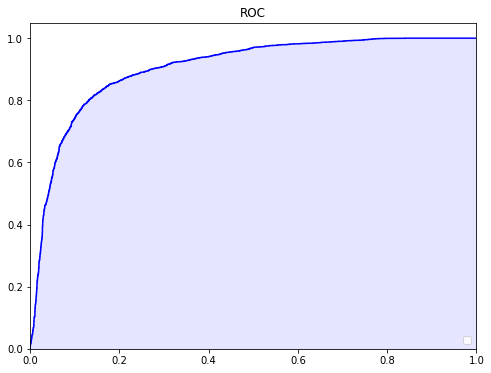

In [82]:
# ROC curve FFT
from sklearn.metrics import roc_curve, auc, roc_auc_score

# before anomaly "negatives"
before_anomaly1 = dt.datetime(2020,1,7,0,0,0)  # before anomaly "negatives"
after_anomaly1 = dt.datetime(2020,1,14,0,0,0)  
before_anomaly2 = dt.datetime(2020,1,27,0,0,0) 
after_anomaly2 = dt.datetime(2020,1,31,0,0,0)

df_inputb2.loc[df_inputb2.index < before_anomaly1,'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly1) &
           (df_inputb2.index < after_anomaly1),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly1) &
           (df_inputb2.index < before_anomaly2),'actual'] = 0
df_inputb2.loc[(df_inputb2.index > before_anomaly2) &
           (df_inputb2.index < after_anomaly2),'actual'] = 1
df_inputb2.loc[(df_inputb2.index > after_anomaly2),'actual'] = 0


yyy_test = df_inputb2['actual'].values

np_range = np.arange(0, 151, 1)
score_list = []
fpr_list = []
tpr_list = []
roc_auc_list = []
for ths in np_range:
    yyy_score_ = (np.greater(df_inputb2[fft], ths) | np.greater(df_inputb2[sal], ths)).astype(int)
    score_list.append(yyy_score_)
    fpr_, tpr_, _ = roc_curve(yyy_test, yyy_score_)
    fpr_list.append(fpr_)
    tpr_list.append(tpr_)
    roc_auc_list.append(auc(fpr_,tpr_))

    
yy_score = np.asarray(score_list)
fpr = np.asarray(fpr_list)
tpr = np.asarray(tpr_list)
roc_auc = np.asarray(roc_auc_list)

yyF_score = np.maximum(df_inputb2[fft].values, df_inputb2[sal].values)
fprF, tprF, _ = roc_curve(yyy_test, yyF_score/200)
roc_aucF = auc(fprF, tprF)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(fprF, tprF, color='blue', lw=1.5)
ax.fill_between(fprF, tprF, y2=0, color='blue', alpha=0.1)
#ax.plot(fpr[20], tpr[20], color='red',lw=1, label='ROC curve 20 (area = %0.2f)' % roc_auc[20])
#ax.plot(fpr[30], tpr[30], color='turquoise',lw=1, label='ROC curve 30 (area = %0.2f)' % roc_auc[30])
#ax.plot(fpr[50], tpr[50], color='orange',lw=1, label='ROC curve 50 (area = %0.2f)' % roc_auc[50])
#ax.plot(fpr[75], tpr[75], color='violet',lw=1, label='ROC curve 75 (area = %0.2f)' % roc_auc[75])
#ax.plot(fpr[100], tpr[100], color='green',lw=1, label='ROC curve 100 (area = %0.2f)' % roc_auc[100])
#ax.plot(fpr[150], tpr[150], color='red',lw=1, label='ROC curve 150 (area = %0.2f)' % roc_auc[150])
#ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate - lower is better, higher means false alerts')
#plt.ylabel('True Positive Rate - higher is better, we detect more anomalies')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
